In [25]:
import pandas as pd
import numpy as np
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

In [37]:
# Function to convert time series data to supervised learning format
def series_to_supervised(data, In=1, out=1, dropnan=True):
    df = pd.DataFrame(data)
    columns = []
    for i in range(In, 0, -1):
        columns.append(df.shift(i))
    for i in range(0, out):
        columns.append(df.shift(-i))
    agg = concat(columns, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# Function to split the data into train and test sets
def train_test_split(data, n):
    return data[:-n, :], data[-n:, :]

# Function to make a one-step forecast with Random Forest
def random_forest_forecast(train, test_x):
    train = np.asarray(train)
    train_x, train_y = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)  # Optimization parameters
    model.fit(train_x, train_y)
    yhat = model.predict([test_x])
    return yhat[0]

# Function for walk-forward validation
def walk_forward_validation(data, test_n):
    predictions = []
    train, test = train_test_split(data, test_n)
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
        print(f'expected={test_y}, predicted={yhat}')
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, history

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecasting the next 90 days
def forecast_next_days(data, n_days):
    predictions = []
    train, test = train_test_split(data, n_days)
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
    return predictions


In [79]:
# Load the dataset
file_path = 'hanoi_quality.csv'  # Adjust the file path as needed
series_all = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
series = series_all['pm25']
# Convert the PM2.5 series to supervised learning
data = series_to_supervised(series.values, In=6)

In [92]:
# Split the data
train_size = int(len(data) * 0.9)
train, test = train_test_split(data, len(data) - train_size)

In [93]:
# Perform walk-forward validation on the test set
mae, y, yhat, history = walk_forward_validation(data, len(test))

expected=152.0, predicted=165.16333333333333
expected=150.0, predicted=84.21482324729968
expected=140.0, predicted=76.25701879798186
expected=137.0, predicted=112.80597991301785
expected=160.0, predicted=147.82244009553287
expected=164.0, predicted=159.78186456625835
expected=187.0, predicted=160.33297135374931
expected=172.0, predicted=165.80339652730308
expected=65.0, predicted=141.42518828021676
expected=103.0, predicted=110.68765613388997
expected=107.0, predicted=98.68443988391795
expected=69.0, predicted=93.29689210523604
expected=112.0, predicted=82.31920439241854
expected=109.0, predicted=107.01757056833536
expected=119.0, predicted=92.40351874218305
expected=133.0, predicted=100.35237075576092
expected=141.0, predicted=118.88621766556088
expected=79.0, predicted=135.6591891311082
expected=88.0, predicted=80.57221200237879
expected=102.0, predicted=94.44905512042546
expected=79.0, predicted=91.03005175566511
expected=87.0, predicted=79.0720356330723
expected=75.0, predicted=94.

In [94]:
print('MAE:', mae)
# Calculate RMSE
rmse = mean_squared_error(y, yhat, squared=False)
print('RMSE:', rmse)
mape = mean_absolute_percentage_error(y, yhat)
print('MAPE:', mape)

MAE: 27.144995513343193
RMSE: 35.7364502163971
MAPE: 56.74132979530714


In [95]:
# Fit the model on the entire dataset with optimization parameters
model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
model.fit(data[:, :-1], data[:, -1])
# Forecast the next 90 days
n_days = 90
forecast = forecast_next_days(data, n_days)

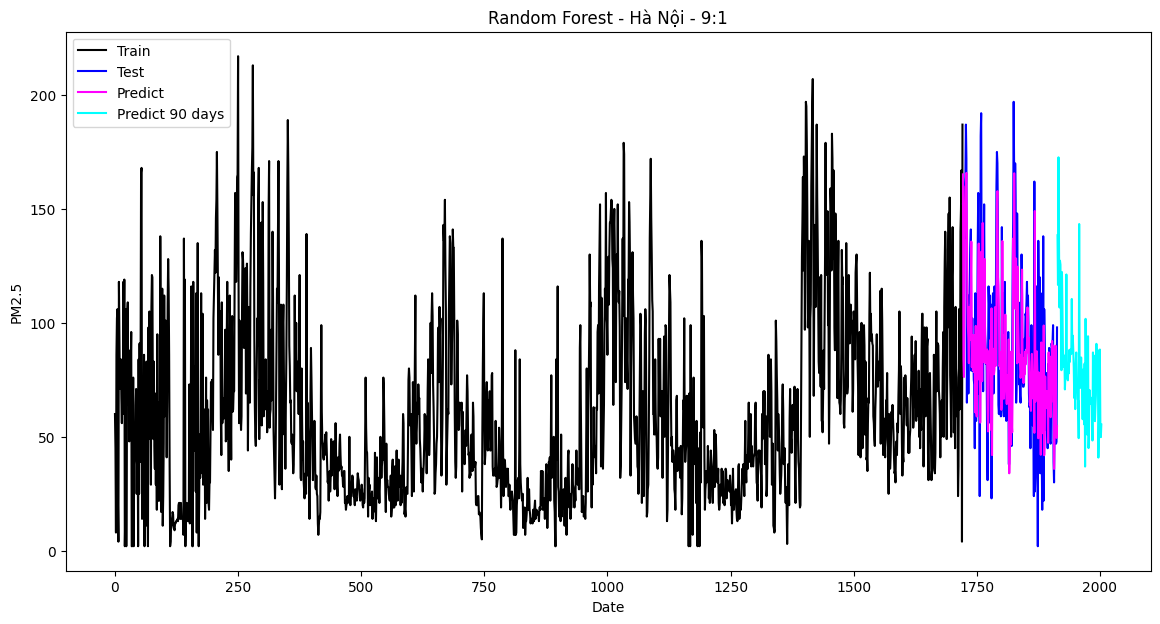

In [96]:
# Prepare data for plotting
train_index = range(len(train))
test_index = range(len(train), len(train) + len(test))
forecast_index = range(len(train) + len(test), len(train) + len(test) + n_days)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_index, [x[-1] for x in train], color='black', label='Train')
plt.plot(test_index, y, color='blue', label='Test')
plt.plot(test_index, yhat, color='magenta', label='Predict')
plt.plot(forecast_index, forecast, color='cyan', label='Predict 90 days')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.title('Random Forest - Hà Nội - 9:1')
plt.show()


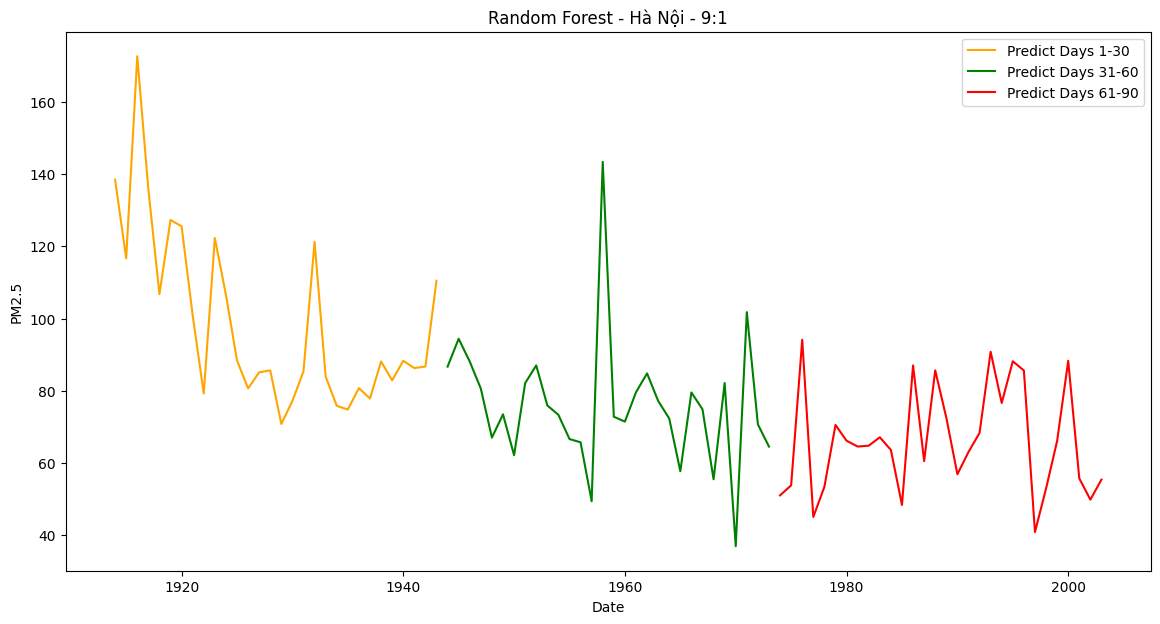

In [97]:
plt.figure(figsize=(14, 7))

# Split forecast into 3 segments
segment_size = 30
forecast_segments = [forecast[i*segment_size:(i+1)*segment_size] for i in range(3)]
colors = ['orange', 'green', 'red']  # Màu cho từng phần
for i, segment in enumerate(forecast_segments):
    plt.plot(forecast_index[i*segment_size:(i+1)*segment_size], segment, color=colors[i], label=f'Predict Days {i*segment_size+1}-{(i+1)*segment_size}')

plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.title('Random Forest - Hà Nội - 9:1')
plt.show()
